# Projet Intelligence Artificielle - Proposition de solution pour le client HumanForYou

## 1. Introduction

### 1.1 Contexte

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

    - Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

    - Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

    - Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

La direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

### 1.2 Importation des bibliothèques utilisées dans le projet

In [ ]:
# Import des différentes librairies
import pandas as pd #lecture CSV
import numpy as np #mathématiques
import sklearn as skl #modèle et autres
%matplotlib inline
import matplotlib  #plotting
import matplotlib.pyplot as plt

# pour que tout soit lisible
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Pour splitting des données
from sklearn.model_selection import train_test_split

# Pour préparation de la pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Pour vérification modèle et évaluation
from sklearn.model_selection import cross_val_score, cross_val_predict # cross-validation scores
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, roc_auc_score # RMSE, MAE, precision, recall, courbe en dessous du ROC
import math # square root
from sklearn.metrics import precision_recall_curve, roc_curve # courbe precision / recall
from sklearn.metrics import confusion_matrix # matrice de confusion

# Helper pour retirer les warnings liés aux convergences
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.metrics import f1_score

# Régression linéaire
from sklearn.linear_model import LinearRegression
# Forêt aléatoire
from sklearn.ensemble import RandomForestClassifier
# Arbre de décision
from sklearn.tree import DecisionTreeRegressor
# Support Vector Classification
from sklearn.svm import SVC
# Classifieur binaire
from sklearn.linear_model import SGDClassifier
# Un bonus, XGBoost
import xgboost as xgb

### 1.3 Helpers

In [ ]:
# Helpers pour MatPlot

# Permet de générer la courbe ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taux de Faux Positifs', fontsize=16)
    plt.ylabel('Taux de Vrai Positifs', fontsize=16)

# Permet de générer la courbe precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

# Permet de générer la courbe precision, recall et threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Seuil", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

# Helpers pour affichage résultats

def display_scores(scores):
    print("Scores: \n", scores)
    print("Moyenne:", scores.mean())
    print("Ecart-type:", scores.std())

## 2. Data Wrangling

Sur cette partie, nous nettoierons les données et examinerons les différents usages que nous jugeons à la fois non éthiques, et à la fois inutile autant côté données manquantes que dans les données non éthiques.

### 2.1 Ouverture des CSV

In [ ]:
# Ouverture des CSV
dataframe_general = pd.read_csv('./general_data.csv')
dataframe_employee_srv = pd.read_csv('./employee_survey_data.csv')
dataframe_manager_srv = pd.read_csv('./manager_survey_data.csv')

#Vérification
dataframe_general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


### 2.2 Enrichissement

Les données ont un indicateur commun : l'identifiant employé, autrement appelé employeeID.

Ceci nous permet donc de fusionner nos dataframes en une seule : fusioned_dataframe.

Faisons ainsi :

In [ ]:
# Jointure des fichiers
fusioned_dataframe = dataframe_general.merge(dataframe_employee_srv).merge(dataframe_manager_srv)

### 2.3 Nettoyage

#### Drop de données inutiles ou non étiques

In [ ]:
filtered_dataframe = fusioned_dataframe.drop(['EmployeeCount', 'Over18', 'MaritalStatus', 'StandardHours', 'EmployeeID'], axis= 1)

#### Analyse des données manquantes

In [ ]:
# Montrer tous les endroits qui contiennent une valeur NA
filtered_dataframe[filtered_dataframe.isna().any(axis=1)]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
11,36,No,Travel_Rarely,Research & Development,28,1,Life Sciences,Male,1,Laboratory Technician,...,16.0,2,15,10,11,NaN,4.0,3.0,3,3
23,42,No,Travel_Rarely,Research & Development,4,4,Life Sciences,Male,1,Manufacturing Director,...,NaN,4,20,11,6,2.0,3.0,3.0,1,3
40,36,No,Travel_Frequently,Research & Development,8,3,Other,Female,3,Sales Executive,...,4.0,2,1,0,0,3.0,NaN,3.0,2,3
84,31,No,Travel_Rarely,Research & Development,6,3,Medical,Female,3,Manager,...,11.0,5,11,4,10,3.0,4.0,NaN,3,3
111,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,Male,4,Human Resources,...,3.0,5,2,2,2,NaN,2.0,3.0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,45,No,Travel_Rarely,Sales,1,4,Technical Degree,Male,1,Research Scientist,...,20.0,3,17,0,15,2.0,2.0,NaN,3,3
4332,31,No,Travel_Rarely,Sales,2,5,Life Sciences,Male,2,Sales Representative,...,7.0,3,4,0,2,NaN,4.0,3.0,4,3
4345,43,No,Non-Travel,Research & Development,6,2,Medical,Male,1,Healthcare Representative,...,7.0,2,5,2,2,4.0,NaN,4.0,2,4
4395,40,No,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,1,Manufacturing Director,...,9.0,4,9,4,7,1.0,4.0,3.0,2,3


#### Colonnes repérées avec un NA

- NumCompaniesWorked
- TotalWorkingYears
- EnvironmentSatisfaction
- JobSatisfaction
- WorkLifeBalance

In [ ]:
print("Pourcentage de NA sur NumCompaniesWorked: ",round(100*(filtered_dataframe['NumCompaniesWorked'].isnull().sum()/len(filtered_dataframe.index)), 2))
print("Pourcentage de NA sur TotalWorkingYears: ", round(100*(filtered_dataframe['TotalWorkingYears'].isnull().sum()/len(filtered_dataframe.index)), 2))
print("Pourcentage de NA sur EnvironmentSatisfaction: ", round(100*(filtered_dataframe['EnvironmentSatisfaction'].isnull().sum()/len(filtered_dataframe.index)), 2))
print("Pourcentage de NA sur JobSatisfaction: ", round(100*(filtered_dataframe['JobSatisfaction'].isnull().sum()/len(filtered_dataframe.index)), 2))
print("Pourcentage de NA sur WorkLifeBalance: ", round(100*(filtered_dataframe['WorkLifeBalance'].isnull().sum()/len(filtered_dataframe.index)), 2))


Pourcentage de NA sur NumCompaniesWorked:  0.43
Pourcentage de NA sur TotalWorkingYears:  0.2
Pourcentage de NA sur EnvironmentSatisfaction:  0.57
Pourcentage de NA sur JobSatisfaction:  0.45
Pourcentage de NA sur WorkLifeBalance:  0.86


Nous allons donc remplir les valeurs manquantes par la médiane des données correspondantes. La librairie Pandas possède déjà de quoi faire pour s'en occuper, nous allons donc l'utiliser.

 #### Remplacement des valeurs vides par la médiane des données.

In [ ]:
# Renseigner les colonnes sur lesquelles il faut opérer
na_values_columns = ["NumCompaniesWorked", "TotalWorkingYears", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance"]

# Pour chaque colonne à traiter...
for column in na_values_columns:
    # ...on remplit les valeurs vides avec la médiane !
    filtered_dataframe[column].fillna(filtered_dataframe[column].mean(), inplace = True)

#### Analyse de typage

In [ ]:
filtered_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MonthlyIncome            4410 non-null   int64  
 11  NumCompaniesWorked       4410 non-null   float64
 12  PercentSalaryHike        4410 non-null   int64  
 13  StockOptionLevel         4410 non-null   int64  
 14  TotalWorkingYears       

Nous avons désormais un jeu de données viable. Nous allons nous occuper des catégories autres que les nombres. Les données telles que l'attrition et le genre n'ont que deux choix possible: soit l'un, soit l'autre (oui, non / homme, femme).

Nous allons premièrement remplacer ces valeurs là, puis pour le reste, nous allons les encoder avec un outil spécifique.

In [ ]:
#Nettoyage du jeu de données: Drop les instances correspondantes aux pb de typage.
# Attrition et Gender sont deux valeurs : Oui / Non, Homme / Femme.
fixed_dataframe = filtered_dataframe.replace({"Attrition": {'Yes': 1, 'No': 0}}).replace({"Gender": {'Female': 1, 'Male': 0}})

fixed_dataframe.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,1,1,Research Scientist,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,0,4,Sales Executive,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,0,3,Human Resources,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,0,1,Sales Executive,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


## 3. Analyse des données brutes

Avant d'utiliser des modèles de prédiction, nous allons tenter d'analyser nos données brutes grâce à une matrice de corrélation.

In [ ]:
correlation = fixed_dataframe.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))
correlation

,Age,Attrition,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
Age,1.0,-0.17,-0.0049,-0.029,0.04,-0.013,-0.026,0.35,-0.034,-0.014,0.66,-0.044,0.25,0.17,0.19,0.01,-0.0035,-0.0055,0.018,-0.03
Attrition,-0.17,1.0,-0.0014,-0.018,-0.018,-0.003,-0.024,0.029,0.031,-0.0095,-0.2,-0.039,-0.19,-0.053,-0.18,-0.095,-0.1,-0.049,-0.011,0.023
DistanceFromHome,-0.0049,-0.0014,1.0,-0.0053,0.041,-0.028,-0.025,-0.036,0.039,0.0014,-8.7e-06,0.0072,0.018,0.0086,0.034,0.021,-0.019,0.0091,-0.013,0.042
Education,-0.029,-0.018,-0.0053,1.0,0.0099,0.047,-0.00035,-0.012,-0.031,-0.0075,0.012,0.031,0.0039,0.015,0.018,-0.047,0.0047,-0.015,-0.0099,-0.029
Gender,0.04,-0.018,0.041,0.0099,1.0,0.025,-0.012,0.072,0.0045,-0.019,0.045,0.037,0.011,0.025,0.00013,0.021,-0.014,0.035,-0.024,-0.052
JobLevel,-0.013,-0.003,-0.028,0.047,0.025,1.0,0.048,-0.0098,0.035,-0.03,-0.032,-0.041,-0.044,-0.043,-0.04,-0.03,-0.022,-0.026,-0.018,0.0074
MonthlyIncome,-0.026,-0.024,-0.025,-0.00035,-0.012,0.048,1.0,-0.042,0.013,0.042,-0.019,0.016,0.029,0.06,0.026,-0.0055,-0.0017,0.028,0.017,0.013
NumCompaniesWorked,0.35,0.029,-0.036,-0.012,0.072,-0.0098,-0.042,1.0,0.014,0.044,0.32,-0.013,-0.17,-0.067,-0.14,0.0066,-0.052,0.0078,0.022,-0.001
PercentSalaryHike,-0.034,0.031,0.039,-0.031,0.0045,0.035,0.013,0.014,1.0,0.025,-0.035,-0.036,-0.042,-0.038,-0.047,-0.0054,0.025,-0.042,-0.015,0.63
StockOptionLevel,-0.014,-0.0095,0.0014,-0.0075,-0.019,-0.03,0.042,0.044,0.025,1.0,0.014,-0.067,-0.00079,0.0044,6.2e-05,-0.0029,0.038,-0.0067,0.013,-0.029


Comme on peut le voir sur cette matrice de corrélation, les données brutes ne nous permettent pas de voir ce qui peut causer le turn over de 15%. 

Il serait donc pertinent d'utiliser des algorithmes de machine learning pour essayer de déceler quels attributs sont à l'origine de l'envie des employés de changer d'entreprise.

## 4. Préparation du jeu de données pour entraînement modèle

### 4.1 One-Hot encodage des attributs catégoriques et remplacement des valeurs non disponibles

In [ ]:
# Nous allons One-Hot encode toutes les catégories, car elles ne peuvent pas être prises par les modèles en tant que tel.

# renseigner les colonnes à one-hot encode
one_hot_var = ["BusinessTravel", "Department", "EducationField", "JobRole"]

test_dataframe = fixed_dataframe.copy()

for i in one_hot_var:
    # one-hot encode toutes les colonnes mentionnées et le met dans une variable x_t
    x_t = pd.get_dummies(test_dataframe[i], prefix=i, prefix_sep='_', drop_first=True)
    # lier la colonne one-hot encodée à l'intérieur du dataframe
    test_dataframe = test_dataframe.join(x_t)
    # et virer la colonne originale, car on en à plus besoin
    test_dataframe.drop(i, axis = 1, inplace = True)

# Vérification que tout soit one-hot encode.
test_dataframe

,Age,Attrition,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,...,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,51,0,6,2,1,1,131160,1.0,11,0,...,0,0,0,0,0,0,0,0,0,0
1,31,1,10,1,1,1,41890,0.0,23,1,...,0,0,0,0,0,0,0,1,0,0
2,32,0,17,4,0,4,193280,1.0,15,3,...,1,0,0,0,0,0,0,0,1,0
3,38,0,2,5,0,3,83210,3.0,11,3,...,0,0,1,0,0,0,0,0,0,0
4,32,0,10,1,0,1,23420,4.0,12,2,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0,5,4,1,1,60290,3.0,17,1,...,0,0,0,0,0,0,0,1,0,0
4406,29,0,2,4,0,1,26790,2.0,15,0,...,0,0,0,1,0,0,0,0,0,0
4407,25,0,25,2,0,2,37020,0.0,20,0,...,0,0,0,0,0,0,0,0,1,0
4408,42,0,18,2,0,1,23980,0.0,14,1,...,0,0,0,1,0,0,0,0,0,0


### 4.2 Traitement des valeurs inexistantes, scaling des données et création du jeu d'entraînement / test

In [ ]:
# Les données d'entraînement
X = test_dataframe.drop('Attrition', axis = 1)

# Ce qu'on veut prédire
y = test_dataframe['Attrition']

# On splitte et shuffle les données (stratified split)
from sklearn.utils import shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

# Import du scaler, pour éviter qu'un attribut soit considéré comme plus important qu'un autre.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# On scale uniquement les données de base, pas les données one-hot encodées
X_train[X_train.columns[:21]] = scaler.fit_transform(X_train[X_train.columns[:21]])
X_test[X_train.columns[:21]] = scaler.transform(X_test[X_train.columns[:21]])

# Shuffle
X_train, y_train = shuffle(X_train, y_train)

## 5. Test des différents modèles de prédiction

Cette partie permettra de voir quel est le modèle le plus adapté à notre problème.

In [ ]:
# Pour prédire naivement une donnée, nous pourrons réutiliser ceci.
une_personne = X_test.iloc[452]
label_a_predire = y_test.iloc[452]

print("Valeur à prédire: ", label_a_predire)

Valeur à prédire:  0


### 5.1 Modèle&nbsp;Random&nbsp;Forest

Prédiction naïve:  [0]
Scores cross-validation:  [0.95663265 0.95918367 0.94727891]
Matrice de confusion: 
 [[2934   25]
 [ 136  433]]
Précision du classifieur:  0.9454148471615721
Recall du classifieur:  0.7609841827768014
F1-score (précision et recall proches):  0.8432327166504382


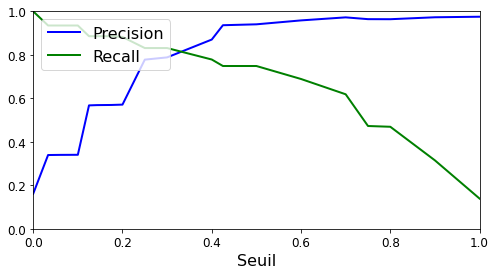

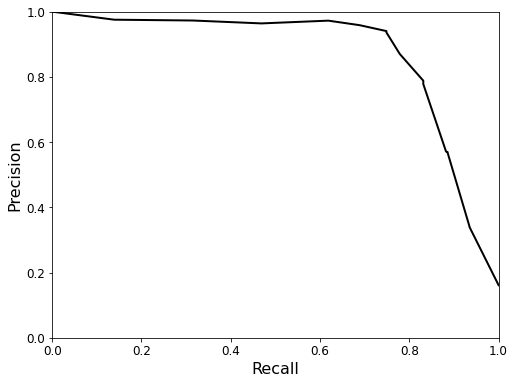

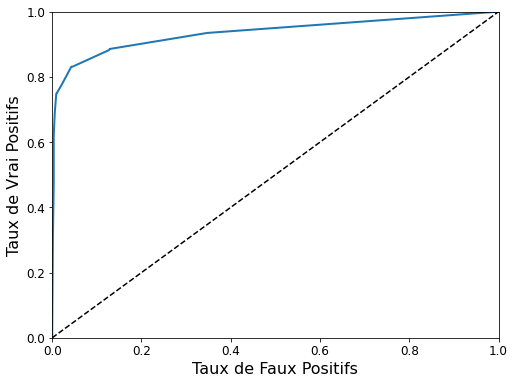

Aire sous la courbe ROC:  0.9353620748946796


In [ ]:
#Création du modèle
clf = RandomForestClassifier(random_state=42, n_estimators=10)
clf.fit(X_train.values, y_train.values)

print("Prédiction naïve: ", clf.predict([une_personne]))

#Evaluation du modèle
print("Scores cross-validation: ", cross_val_score(clf, X_train.values, y_train.values, cv=3))
forest_pred = cross_val_predict(clf, X_train.values, y_train.values, cv=3)
print("Matrice de confusion: \n", confusion_matrix(y_train.values, forest_pred))
print("Précision du classifieur: ", precision_score(y_train.values, forest_pred))
print("Recall du classifieur: ", recall_score(y_train.values, forest_pred))
print("F1-score (précision et recall proches): ", f1_score(y_train.values, forest_pred))
forest_scores = cross_val_predict(clf, X_train.values, forest_pred, cv=3,
                             method="predict_proba")
good_forest_scores = forest_scores[:, 1]
precisions, recalls, thresholds_pr = precision_recall_curve(y_train.values, good_forest_scores)
fpr, tpr, thresholds_ftpr = roc_curve(y_train.values, good_forest_scores)

# Regarder le graphe precision, recall vs threshold
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds_pr)
plt.xlim([0, 1])
plt.show()

# Regarder le graphe precision vs recall
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Regarder le graphe ROC
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()
print("Aire sous la courbe ROC: ", roc_auc_score(y_train.values, good_forest_scores))

### 5.2 Modèle Support&nbsp;Vector&nbsp;Classification

Scores cross-validation:  [0.79676871 0.80612245 0.80357143]
Matrice de confusion: 
 [[2793  166]
 [ 532   37]]
Précision du classifieur:  0.18226600985221675
Recall du classifieur:  0.06502636203866433
F1-score (précision et recall proches):  0.09585492227979275


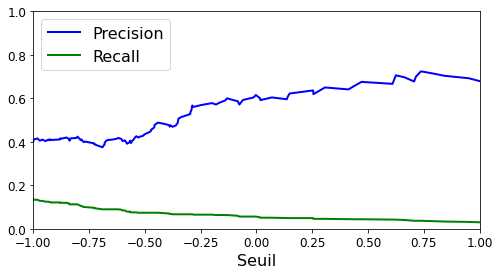

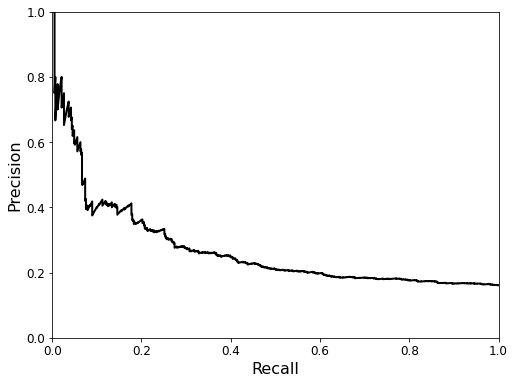

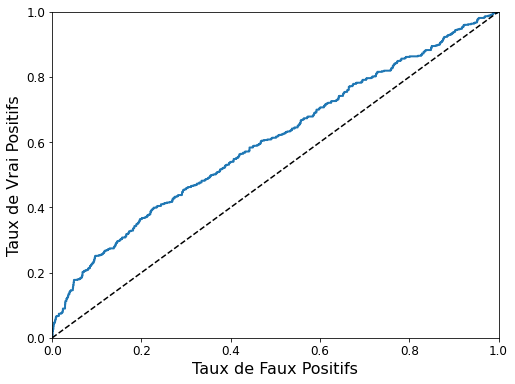

Aire sous la courbe ROC:  0.6023890653221442
Prédiction:  [0]


In [ ]:
#préparation du modèle (sigmoïde car il s'agit de l'activation de la régression logistique)
svm_class = SVC(kernel="sigmoid", random_state=42)
svm_class = svm_class.fit(X_train.values, y_train.values)

#évaluation du modèle
print("Scores cross-validation: ", cross_val_score(svm_class, X_train.values, y_train.values, cv=3, scoring="accuracy"))
svm_pred = cross_val_predict(svm_class, X_train.values, y_train.values, cv=3)
print("Matrice de confusion: \n", confusion_matrix(y_train.values, svm_pred))
print("Précision du classifieur: ", precision_score(y_train.values, svm_pred))
print("Recall du classifieur: ", recall_score(y_train.values, svm_pred))
print("F1-score (précision et recall proches): ", f1_score(y_train.values, svm_pred))
svm_scores = cross_val_predict(svm_class, X_train.values, svm_pred, cv=3,
                             method="decision_function")
precisions, recalls, thresholds_pr = precision_recall_curve(y_train.values, svm_scores)
fpr, tpr, thresholds_ftpr = roc_curve(y_train.values, svm_scores)

# Regarder le graphe precision, recall vs threshold
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds_pr)
plt.xlim([-1, 1])
plt.show()

# Regarder le graphe precision vs recall
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Regarder le graphe ROC
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()
print("Aire sous la courbe ROC: ", roc_auc_score(y_train.values, svm_scores))

#prédiction naive
print("Prédiction: ", svm_class.predict([une_personne]))


### 5.3 Modèle Classifieur SGD

Prédiction:  [0]
Scores cross-validation:  [0.83673469 0.83928571 0.83928571]
Matrice de confusion: 
 [[2872   87]
 [ 483   86]]
Précision du classifieur:  0.49710982658959535
Recall du classifieur:  0.15114235500878734
F1-score (précision et recall proches):  0.23180592991913745


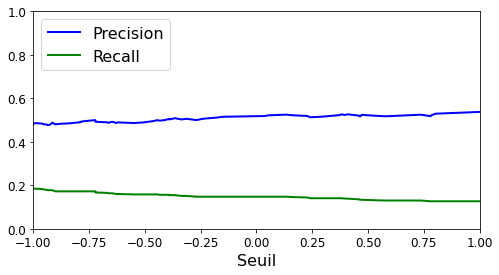

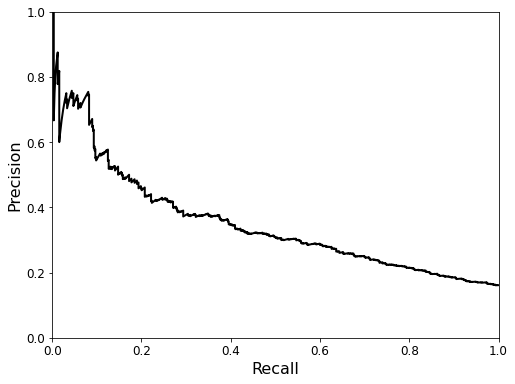

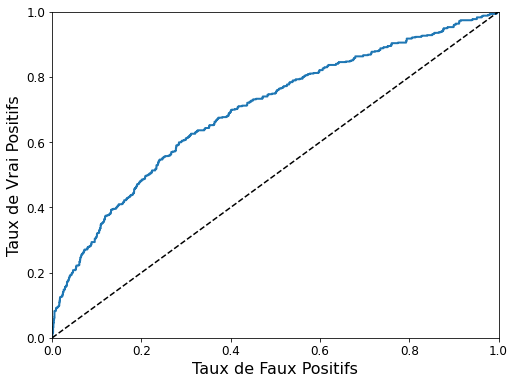

Aire sous la courbe ROC:  0.6966604520716934


In [ ]:
sgd_clf = SGDClassifier(max_iter=50, random_state=42)
sgd_clf.fit(X_train.values, y_train.values) # Entrainement du modèle

print("Prédiction: ", sgd_clf.predict([une_personne]))

print("Scores cross-validation: ", cross_val_score(sgd_clf, X_train.values, y_train.values, cv=3, scoring="accuracy"))
sgd_pred = cross_val_predict(sgd_clf, X_train.values, y_train.values, cv=3)
print("Matrice de confusion: \n", confusion_matrix(y_train.values, sgd_pred))

print("Précision du classifieur: ", precision_score(y_train.values, sgd_pred))
print("Recall du classifieur: ", recall_score(y_train.values, sgd_pred))
print("F1-score (précision et recall proches): ", f1_score(y_train.values, sgd_pred))

sgd_scores = cross_val_predict(sgd_clf, X_train.values, sgd_pred, cv=3,
                             method="decision_function")
precisions, recalls, thresholds_pr = precision_recall_curve(y_train.values, sgd_scores)

fpr, tpr, thresholds_ftpr = roc_curve(y_train.values, sgd_scores)

# Regarder le graphe precision, recall vs threshold
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds_pr)
plt.xlim([-1, 1])
plt.show()

# Regarder le graphe precision vs recall
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Regarder le graphe ROC
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()
print("Aire sous la courbe ROC: ", roc_auc_score(y_train.values, sgd_scores))

### 5.4 Modèle XGBoost

Prédiction:  [0]
Scores cross-validation:  [0.95833333 0.96598639 0.96003401]
Matrice de confusion: 
 [[2932   27]
 [ 109  460]]
Précision du classifieur:  0.944558521560575
Recall du classifieur:  0.8084358523725835
F1-score (précision et recall proches):  0.8712121212121213


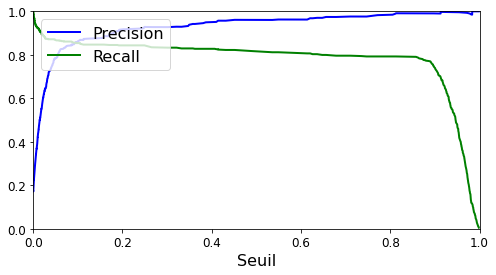

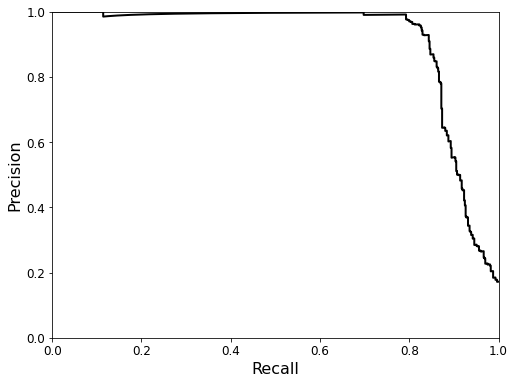

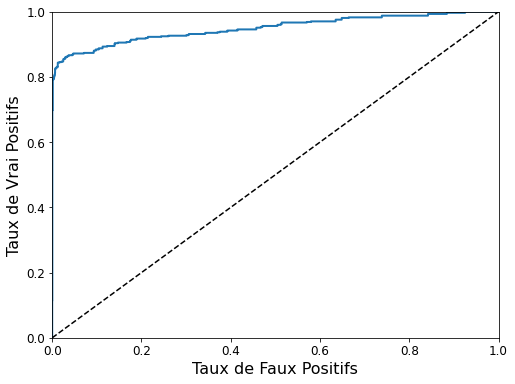

Aire sous la courbe ROC:  0.9485534881814797


In [ ]:
#XGBoost
boost = xgb.XGBClassifier(objective="reg:logistic", eval_metric='auc', use_label_encoder=False)
boost.fit(X_train.values, y_train.values)

print("Prédiction: ", boost.predict([une_personne]))

print("Scores cross-validation: ", cross_val_score(boost, X_train.values, y_train.values, cv=3, scoring="accuracy"))
boost_pred = cross_val_predict(boost, X_train.values, y_train.values, cv=3)
print("Matrice de confusion: \n", confusion_matrix(y_train.values, boost_pred))

print("Précision du classifieur: ", precision_score(y_train.values, boost_pred))
print("Recall du classifieur: ", recall_score(y_train.values, boost_pred))
print("F1-score (précision et recall proches): ", f1_score(y_train.values, boost_pred))

boost_scores = cross_val_predict(boost, X_train.values, boost_pred, cv=3, method="predict_proba")
boost_good_scores = boost_scores[:, 1]
precisions, recalls, thresholds_pr = precision_recall_curve(y_train.values, boost_good_scores)

fpr, tpr, thresholds_ftpr = roc_curve(y_train.values, boost_good_scores)

# Regarder le graphe precision, recall vs threshold
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds_pr)
plt.xlim([0, 1])
plt.show()

# Regarder le graphe precision vs recall
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Regarder le graphe ROC
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()
print("Aire sous la courbe ROC: ", roc_auc_score(y_train.values, boost_good_scores))

Après test des différents algorithmes de classification, nous avons constaté les résultats suivants :

Les résultats ci-dessous sont basés sur leur F1-score.

- XGBoost : 0.87
- Random Forest : 0.84
- SGD : 0.23
- SVC : 0.09

Après analyse de nos résultats, nous constatons que XGBoost est le plus adapté pour résoudre notre problèmatique car son F1-score est très bon : 0.87 (precision/recall proches autour de 88%). Le random forest arrive juste derrière avec un F1-score de 0.84 (precision/recall proches autour de 84%).

## 6. Choix et amélioration du modèle

Nous avons donc gardé XGBoost en tant que modèle. Nous devons donc trouver les paramètres optimaux pour ce modèle. Nous pourrons ensuite le réentraîner avec les paramètres modifiés pour ensuite l'exporter pour un usage prochain.

### 6.1 Optimisation des hyperparamètres

Ici, on va essayer d'optimiser les hyperparamètres de notre algo pour retourner de meilleurs résultats.
Pour ça, on va utiliser tester deux algorithmes: RandomizedSearch et GridSearch.

#### RandomizedSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}

xgb_random_test = xgb.XGBClassifier(random_state=42, objective="reg:logistic", use_label_encoder=False)

random_search = RandomizedSearchCV(xgb_random_test, params, cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           objective='reg:logistic',
                                           predictor=None, random_state=42,
                                    

In [ ]:
random_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 1,
 'colsample_bytree': 0.8}

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='reg:logistic', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
cv_res = random_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)

0.9121306732565848 {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 1.0}
0.9713708235388665 {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.8}
0.9543668253872581 {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}
0.8843565788680611 {'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 1.0}
0.9248837723263618 {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 1.0}
0.9050481184577984 {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.8}
0.9586173226448074 {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.8}
0.9501119080626041 {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.8}
0.8917268398529323 {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 3, 'gam

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}

xgb_grid_test = xgb.XGBClassifier(random_state=42, objective="reg:logistic", use_label_encoder=False)

grid_search = GridSearchCV(xgb_grid_test, params, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     objective='reg:logistic', predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_

In [ ]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

In [ ]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='reg:logistic', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
cv_res2 = grid_search.cv_results_
for mean_score, params in zip(cv_res2['mean_test_score'], cv_res2['params']):
    print(mean_score, params)

0.9197838185361542 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
0.9197838185361542 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
0.9186518795330801 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
0.9022108372008921 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}
0.9118506017318626 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
0.9087296325316938 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
0.8900243103690755 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}
0.8962630341751552 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8}
0.8973949731782291 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth'

Malgré le temps d'attente assez long (GridSearch peut prendre jusqu'à 45/50 minutes !), nous avons les paramètres optimaux pour notre modèle, avec, encore une fois, une précision qui dépasse toutes nos attentes (97% de fiabilité, donc il à environ 3% de chances de se tromper, ce qui est minime.)

Nous pouvons désormais recréer notre modèle avec les paramètres optimaux, l'entraîner et l'exporter pour un usage prochain.

### 6.2 Sauvegarde du modèle

On peut sauvegarder et recharger un modèle grâce à&nbsp;joblib. C'est utile car il permet de garder l'état du modèle après entraînement, mais aussi lorsque cet entraînement à nécessité beaucoup de temps-machine.

In [ ]:
import joblib

boost = xgb.XGBClassifier(random_state=42, objective="reg:logistic", use_label_encoder=False, subsample = 1.0, min_child_weight = 1, max_depth = 5, gamma = 1, colsample_bytree = 0.6)
# Le tester comme ça pour avoir les feature names
boost.fit(X_train, y_train)

joblib.dump(boost, "test.pkl")

['test.pkl']

## 7. Conclusion

Ici, on va afficher les attributs permettant à notre algorithme de prédire si un employé va changer d'entreprise. Ces attributs seront triés par ordre d'importance.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

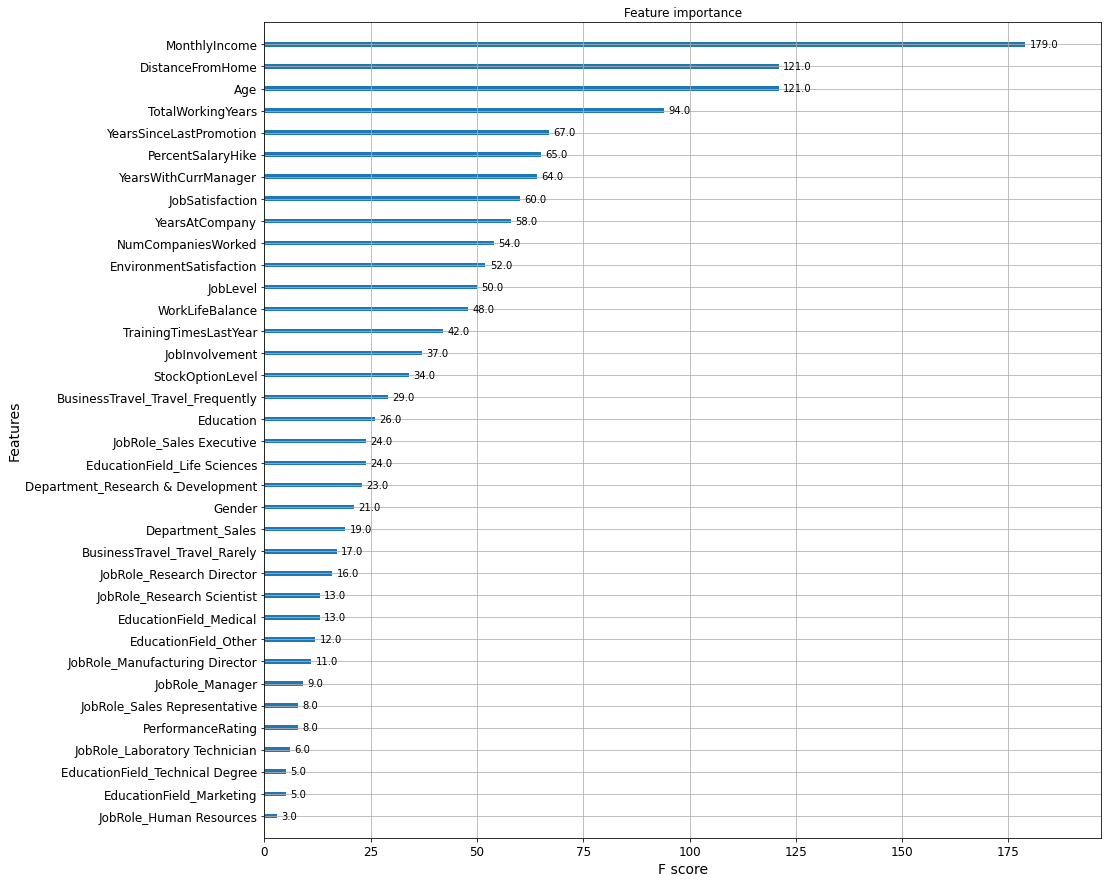

In [ ]:
test = joblib.load("test.pkl")
plt.rcParams["figure.figsize"] = (15, 15)
xgb.plot_importance(test)

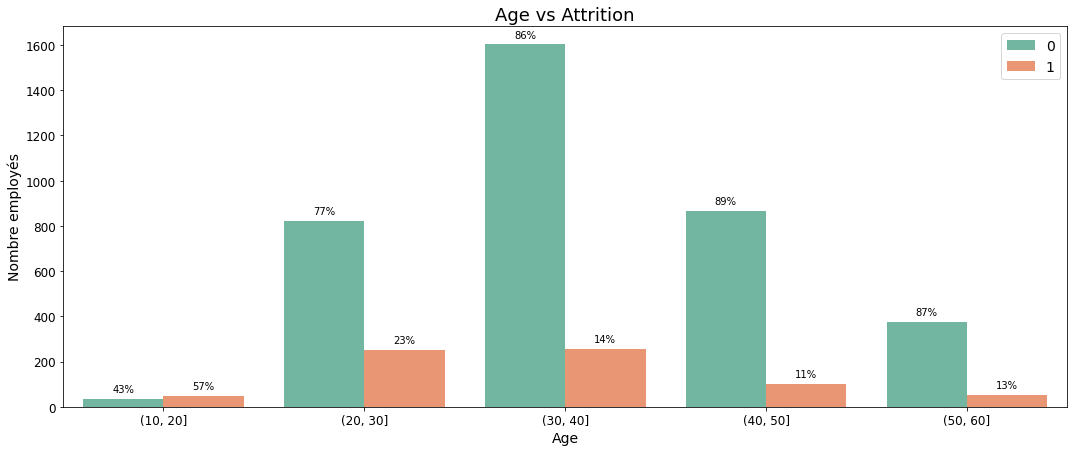

In [ ]:
import seaborn as sns

# Initialize a figure
plt.figure(figsize = (18,7))

fixed_dataframe.Age = pd.cut(fixed_dataframe.Age, range(10, 70, 10))
    
# Generate a countplot for the passed feature_name
ax = sns.countplot(x="Age", hue='Attrition', data=fixed_dataframe, palette='Set2')
x_ticks = 'not_needed'
        
# set title, xlabel, ylabel, legend
plt.xlabel("Age",fontsize  = 14)
plt.ylabel('Nombre employés',fontsize  = 14)
plt.title('Age vs Attrition'.format("Age"), fontsize = 18)
plt.legend(fontsize = 14)

# Check if custom x_tick is needed or not
if x_ticks != 'not_needed':
    # Generate index of xticks
    ticks_index = [i for i in range(len(x_ticks))]
        
    # set new xticks by passing ticks_index and custom xtick labels 
    ax.set(xticks=ticks_index, xticklabels=x_ticks)

# From axis.patches get bar lengths
get_bars = ax.patches
half_bar_length = int(len(get_bars)/2)
bar_left = get_bars[:half_bar_length]
bar_right = get_bars[half_bar_length:]
    
# Place %employees on top of each bar
for L, R in zip(bar_left, bar_right):
    left_height = L.get_height()
    right_height = R.get_height()
    length_total = left_height + right_height

    # place calculated employee percentage on top of each bar
    ax.text(L.get_x() + L.get_width()/2., left_height + 30, '{0:.0%}'.format(left_height/length_total), ha="center")
    ax.text(R.get_x() + R.get_width()/2., right_height + 30, '{0:.0%}'.format(right_height/length_total), ha="center")

Nous pouvons donc distinguer 4 grands facteurs considéré comme important par le modèle entraîné.

Selon lui, le salaire, la distance travail-maison, l'âge ainsi que l'expérience de l'employé sont des facteurs importants sur lesquels l'entreprise pourrait travailler pour conserver ses employés et éviter le turn over de 15% chaque année.

Nous proposons différentes pistes de solution :

- Prise en charge partielle du coût du trajet travail-maison: pour aider les employés vivant loin du lieu de travail.
- Revalorisation salariale vis-a-vis des prix du marché: pour garder les employés plus longtemps, mais aussi pour éviter qu'un employé "trouve mieux ailleurs".
- En correspondance avec le graphique ci-dessus, nous pouvons travailler sur la rétention des plus jeunes employés en les fidélisant mieux via des évènements internes par exemple.
- Donner des avantages aux employés ayant beaucoup d'expérience (promotions à un rang supérieur, augmentation de salaire proportionnelle à l'expérience etc...)